In [1]:
#data
import pandas as pd
import os
import statsmodels.stats.multitest as multi
import numpy as np
import json

In [2]:
#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
#statistics
from scipy.stats import mannwhitneyu
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import mannwhitneyu
from scipy import stats
from sklearn import preprocessing
#model
from sklearn.utils import resample
from sklearn.linear_model import Lasso
import sklearn.metrics as metrics
import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

### Get UKBB risk variants

In [4]:
with open('/cellar/users/mpagadal/resources/tcga/ensembl_map.json', 'r') as f:
    ensembl = json.load(f)
ensembl={k.split(".")[0]:v for k,v in ensembl.items()}

In [5]:
def make_ukbb_prs(raw,sumstats,snps):
    
    print("{} PRS snps".format(len(snps)))
    
    #compile raw files
    compiled_raw=pd.read_csv(raw,delim_whitespace=True)
    
    #keep snps in list
    keep_snps=[]
    
    for x in snps:
        try:
            keep_snps.append([s for s in compiled_raw.columns if x in s][0])
        except:
            try:
                keep_snps.append([s for s in compiled_raw.columns if x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] in s][0])
            except:
                pass
    
    compiled_raw=compiled_raw[["IID"]+keep_snps]
    
    #format raw files
    compiled_raw=compiled_raw.set_index("IID")
    compiled_raw=compiled_raw.T
    compiled_raw["min_allele"]=compiled_raw.index.str.split("_").str[-1]
    
    #remove duplicates
    compiled_raw["snp"]=compiled_raw.index.str.split("_").str[0]
    compiled_raw=compiled_raw[~compiled_raw["snp"].duplicated()]
    del compiled_raw["snp"]
    
    compiled_raw.index=compiled_raw.index.str.rsplit(":",2).str[0]
    
    #reformat summary
    summary_merge=sumstats[["ID","A1","OR"]].copy()
    summary_merge=summary_merge.drop_duplicates(subset="ID",keep="first")
    summary_merge=summary_merge.set_index("ID")
    summary_merge.index=summary_merge.index.str.rsplit(":",2).str[0]
    
    #annotate the genotypes
    compiled_raw=pd.merge(compiled_raw,summary_merge, left_index=True,right_index=True,how="left")
    print("{} snps missing weight".format(len(compiled_raw[compiled_raw["OR"].isnull()])))
    
    compiled_raw["logOR"]=np.log2(compiled_raw["OR"])
    del compiled_raw["OR"]
    compiled_raw=compiled_raw[~compiled_raw["logOR"].isnull()] #remove null weights
    compiled_raw["logOR"]=np.where(compiled_raw["min_allele"]!=compiled_raw["A1"],compiled_raw["logOR"]*-1,compiled_raw["logOR"]) #orient the odds ratio
    print("switching {} genotypes".format(len(compiled_raw[compiled_raw["min_allele"]!=compiled_raw["A1"]]))) #number of mismatched genotypes

    del compiled_raw["min_allele"]
    del compiled_raw["A1"]

    #get beta values
    mp_beta=dict(zip(compiled_raw.index,compiled_raw["logOR"]))
    compiled_raw_switch=compiled_raw.iloc[:,:-1].T
    
    #align to all positive snps
    switch_snps=[k for k,v in mp_beta.items() if v < 0]
    
    compiled_raw_switch=compiled_raw_switch.fillna(0)
    
    for x in switch_snps:
        compiled_raw_switch[x]=2-compiled_raw_switch[x]
        
    compiled_raw_switch=compiled_raw_switch.T
    compiled_raw_switch["beta"]=compiled_raw_switch.index.map(mp_beta)
    compiled_raw_switch["beta"]=abs(compiled_raw_switch["beta"])
    compiled_raw_switch=compiled_raw_switch.astype(float)
    
    #compile weighted genotypes
    compiled_raw_switch_out=compiled_raw_switch.iloc[:,:-1].mul(compiled_raw_switch["beta"],axis=0)
    raw_prs=compiled_raw_switch.iloc[:,:-1].mul(compiled_raw_switch["beta"],axis=0).sum(axis=0).reset_index()
    raw_prs.columns=["IID","PRS"]
    
    return(raw_prs,compiled_raw_switch_out)

In [6]:
def quantile_plot(df,form,num,lin_log):
    '''
    df: dataframe with PRS and pheno/cov in form
    prs: prs column
    form: formula for analysis
    num: number of quantiles
    '''
    
    if lin_log == "logistic":
        
        quant=[]
        odds=[]
        se=[]

        for i in range(num):
            quant.append(str((100/num)*i))
    
            #make groupings for logistic regression
            
            cases=df[(df["PRS"]>df["PRS"].quantile((1/num)*i))&(df["PRS"]<df["PRS"].quantile((1/num)*(i+1)))]["FID"].tolist()
            
            controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(df["PRS"]<df["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
    
            df_filt=df[df["FID"].isin(cases+controls)]
            #df_filt=df[df["FID"].isin(cases)]

            df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)
            print(df_filt["group"].value_counts())
            
            if i != int(num/2):
                model=smf.logit(form,data=df_filt).fit()
                odds.append(np.exp(model.params.tolist()[1]))
                se.append(model.bse.tolist()[1])
            else:
                odds.append(1)
                se.append(0)
                
        df_odds=pd.DataFrame({"quant":quant,"odds":odds,"se":se})
        return(df_odds)

In [7]:
snps=pd.read_csv("../tables/time-germline.csv",delimiter="\t")
snps["snp_noallele"]=snps["proxy_variant"].str.rsplit(":",2).str[0]
mp_variant=dict(zip(snps["proxy_snp"],snps["proxy_variant"]))

In [8]:
ukbb=pd.read_csv("../tables/supplementary_table_10.csv")

In [9]:
fdr_thresh=0.05

In [10]:
ukbb_sig=ukbb[ukbb["Overall_Pval"]<fdr_thresh]
ukbb_sig=ukbb_sig[ukbb_sig["Outcome"].str.startswith("C")]
ukbb_annot=pd.merge(ukbb_sig, snps, on="proxy_variant", how="left")
pheno_group=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/networkx/networkx.group.csv")
pheno_group["nodes"]=pheno_group["nodes"].str.replace(".","-")
mp_group=dict(zip(pheno_group["nodes"],pheno_group["group"]))
ukbb_annot["group"]=ukbb_annot["file"].map(mp_group)
ukbb_sig["proxy_variant"]=ukbb_sig["Var1_ID"].map(mp_variant).fillna(ukbb_sig["Var1_ID"])

#annotate dataframe
ukbb_sig_snps=ukbb_sig["proxy_variant"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in ukbb_sig["proxy_variant"].tolist()]
snps["ukbb"]=np.where(snps["proxy_variant"].isin(ukbb_sig_snps),"ukbb","no")

In [11]:
print("{} UKBB associations from {} IP components".format(len(snps[snps["ukbb"]=="ukbb"]["proxy_variant"].unique()),len(snps[snps["ukbb"]=="ukbb"]["file"].unique())))

619 UKBB associations from 112 IP components


In [12]:
#get significant UKBB associations 
    #filter for cancer associations: Outcome ICD10 codes - C
    #Adjusted for pval instead of FDR thresh
    
ukbb_sig=ukbb[ukbb["Overall_Pval"]<fdr_thresh]
ukbb_sig=ukbb_sig[ukbb_sig["Outcome"].str.startswith("C")]
ukbb_sig["proxy_variant"]=ukbb_sig["Var1_ID"].map(mp_variant).fillna(ukbb_sig["Var1_ID"])

#annotate dataframe
ukbb_sig_snps=ukbb_sig["proxy_variant"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in ukbb_sig["proxy_variant"].tolist()]
snps["ukbb"]=np.where(snps["proxy_variant"].isin(ukbb_sig_snps),"ukbb","no")

In [13]:
print("{} UKBB associations from {} IP components".format(len(snps[snps["ukbb"]=="ukbb"]),len(snps[snps["ukbb"]=="ukbb"]["file"].unique())))

660 UKBB associations from 112 IP components


In [14]:
ukbb_annot=pd.merge(ukbb_sig, snps, on="proxy_variant", how="left")
ukbb_annot["ukbb_a1"]=ukbb_annot["Var1_MAF"].str.split(":").str[0]
ukbb_annot["beta_match"]=np.where(ukbb_annot['ukbb_a1']!=ukbb_annot["A1"],ukbb_annot["beta"]*-1,ukbb_annot["beta"])
ukbb_annot["logOR"]=np.log10(ukbb_annot["Var1_OR"])
ukbb_annot["ref"]=ukbb_annot["proxy_variant"].str.split(":").str[2]

In [15]:
pheno_group=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/networkx/networkx.group.csv")
pheno_group["nodes"]=pheno_group["nodes"].str.replace(".","-")
mp_group=dict(zip(pheno_group["nodes"],pheno_group["group"]))

In [16]:
ukbb_annot["group"]=ukbb_annot["file"].map(mp_group)

#### group1 PRS

In [17]:
group1_sumstats=ukbb_annot[ukbb_annot["group"]=="group1"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
group1_sumstats=group1_sumstats[np.logical_or(group1_sumstats["Outcome"]=="C43-C44",group1_sumstats["Outcome"]=="C60-C63")] #
group1_sumstats.columns=["ID","A1","OR","Outcome"]

In [18]:
print("{} phenotypes implicated in PRS".format(", ".join(ukbb_annot[(ukbb_annot["group"]=="group1")&(ukbb_annot["Outcome"]=="C43-C44")]["file"].unique())))

CTSW, FCGR3B, CTSS, ERAP1, ERAP2, LYZ, HLA-DQA2, MNDA, HLA-DQA1, HLA-DRB1, HLA-C, MICB, HLA-G, HLA-DQB2, OAS1, TAP2, HLA-DRB5, HLA-DQB1, IL2RA, HLA-H, FPR1, HLA-A, HLA-B phenotypes implicated in PRS


In [19]:
group1_prs,test_ukbb_res=make_ukbb_prs("/cellar/users/mpagadal/projects/germline-immune/data/ukbb/time-snp/dosage-multi/ukbb_bialleleic.raw",group1_sumstats,group1_sumstats["ID"].tolist())
icd=pd.read_csv("/cellar/users/mpagadal/data/ukbb/plato_input/immune_cancer_lev1_pheno.txt",delim_whitespace=True)
group1_prs=pd.merge(group1_prs,icd,on="IID",how="left")

158 PRS snps
0 snps missing weight
switching 128 genotypes


In [20]:
cat1 = group1_prs[group1_prs["C43-C44"]==0]
cat2 = group1_prs[group1_prs["C43-C44"]==1]
mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]

4.5967287409834174e-24

In [21]:
group1_prs["melanoma"]=group1_prs["C43-C44"]
group1_odds=quantile_plot(group1_prs,"melanoma ~ group + AGE + SEX + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10",10,"logistic")

/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    144796
0     38952
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.145063
         Iterations 8


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    144163
0     38952
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.149523
         Iterations 8


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    144060
0     38952
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.151365
         Iterations 8


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    143642
0     38952
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.154279
         Iterations 8


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    143672
0     38952
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.151821
         Iterations 8


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    143522
Name: group, dtype: int64
1    143573
0     38952
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.154011
         Iterations 8


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    143643
0     38952
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.156317
         Iterations 8


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    143694
0     38952
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.160174
         Iterations 8


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    144967
0     38952
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.163967
         Iterations 8


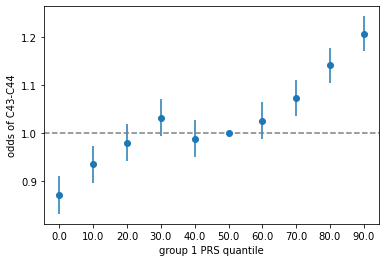

In [22]:
plt.errorbar(x=group1_odds["quant"].tolist(),y=group1_odds["odds"].tolist(),yerr=group1_odds["se"].tolist(),fmt="o")
plt.xlabel("group 1 PRS quantile")
plt.ylabel("odds of C43-C44")
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("../plots/fig3/group1.melanoma.ukbb.prs.quantile.pdf")

#### MHC II signature

In [23]:
mhcII_sumstats=ukbb_annot[ukbb_annot["file"]=="Sigs160-Wolf_MHC2-21978456"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
mhcII_sumstats=mhcII_sumstats[mhcII_sumstats["Outcome"]=="C43-C44"]
mhcII_sumstats.columns=["ID","A1","OR","Outcome"]

In [24]:
mhcII_prs=make_ukbb_prs("../data/ukbb/time-snp/dosage-multi/ukbb_bialleleic.raw",mhcII_sumstats,mhcII_sumstats["ID"].tolist())
icd=pd.read_csv("/cellar/users/mpagadal/data/ukbb/plato_input/immune_cancer_lev1_pheno.txt",delim_whitespace=True)
mhcII_prs=pd.merge(mhcII_prs[0],icd,on="IID",how="left")

13 PRS snps
0 snps missing weight
switching 13 genotypes


In [25]:
cat1 = mhcII_prs[mhcII_prs["C43-C44"]==0]
cat2 = mhcII_prs[mhcII_prs["C43-C44"]==1]
mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]

8.930627728989479e-15

In [26]:
mhcII_prs["melanoma"]=mhcII_prs["C43-C44"]
mhcII_odds=quantile_plot(mhcII_prs,"melanoma ~ group + AGE + SEX + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10",10,"logistic")

/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    145295
0     36505
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.147316
         Iterations 8


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    144262
0     36505
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.155072
         Iterations 8


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    142965
0     36505
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.153260
         Iterations 8


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    141986
0     36505
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.149079
         Iterations 8


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    134254
0     36505
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.150230
         Iterations 8


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    141075
Name: group, dtype: int64
1    142468
0     36505
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.155876
         Iterations 8


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    142989
0     36505
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.159624
         Iterations 8


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    142964
0     36505
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.157950
         Iterations 8


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    144529
0     36505
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.160906
         Iterations 8


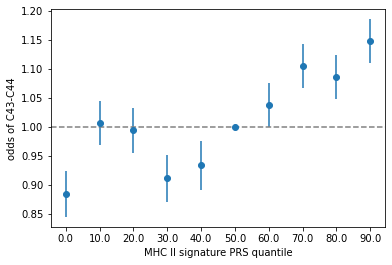

In [27]:
plt.errorbar(x=mhcII_odds["quant"].tolist(),y=mhcII_odds["odds"].tolist(),yerr=mhcII_odds["se"].tolist(),fmt="o")
plt.xlabel("MHC II signature PRS quantile")
plt.ylabel("odds of C43-C44")
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("../plots/fig3/mhcII.sig.melanoma.ukbb.prs.quantile.pdf")

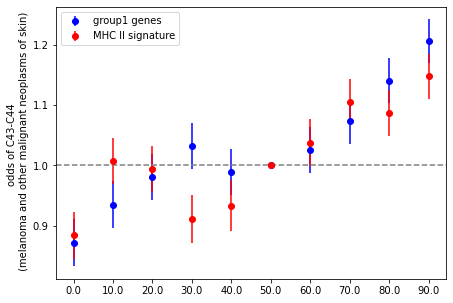

In [28]:
f=plt.figure(figsize=(7,5))
plt.errorbar(x=group1_odds["quant"].tolist(),y=group1_odds["odds"].tolist(),yerr=group1_odds["se"].tolist(),fmt="o",color="blue",label="group1 genes")
plt.errorbar(x=mhcII_odds["quant"].tolist(),y=mhcII_odds["odds"].tolist(),yerr=mhcII_odds["se"].tolist(),fmt="o",color="red",label="MHC II signature")
plt.ylabel("quantile")
plt.ylabel("odds of C43-C44 \n (melanoma and other malignant neoplasms of skin)")
plt.axhline(1,linestyle="--",color="gray")
plt.legend()
plt.savefig("../plots/fig3/mhcI.II.ukbb.quantile.pdf")

### UKBB with combined MHC+group1 SNPs, Melanoma training and validation ONLY

In [29]:
group1_sumstats=ukbb_annot[ukbb_annot["group"]=="group1"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
group1_sumstats=group1_sumstats[np.logical_or(group1_sumstats["Outcome"]=="C43-C44",group1_sumstats["Outcome"]=="C60-C63")] #
group1_sumstats.columns=["ID","A1","OR","Outcome"]

mhcII_sumstats=ukbb_annot[ukbb_annot["file"]=="Sigs160-Wolf_MHC2-21978456"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
mhcII_sumstats=mhcII_sumstats[np.logical_or(mhcII_sumstats["Outcome"]=="C43-C44",mhcII_sumstats["Outcome"]=="C60-C63")]
mhcII_sumstats.columns=["ID","A1","OR","Outcome"]

group1_mhcII_sumstats=group1_sumstats.append(mhcII_sumstats)
group1_mhcII_sumstats

group1_mhc_prs,test_ukbb_res=make_ukbb_prs("../data/ukbb/time-snp/dosage-multi/ukbb_bialleleic.raw",group1_mhcII_sumstats,group1_mhcII_sumstats["ID"].tolist())
icd=pd.read_csv("/cellar/users/mpagadal/data/ukbb/plato_input/immune_cancer_lev1_pheno.txt",delim_whitespace=True)
group1_mhc_prs=pd.merge(group1_mhc_prs,icd,on="IID",how="left")

181 PRS snps
0 snps missing weight
switching 148 genotypes


#### melanoma genes ONLY

In [30]:
random_sate=75 

In [31]:
group1_sumstats=ukbb_annot[ukbb_annot["group"]=="group1"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
group1_sumstats=group1_sumstats[group1_sumstats["Outcome"]=="C43-C44"]
group1_sumstats.columns=["ID","A1","OR","Outcome"]

mhcII_sumstats=ukbb_annot[ukbb_annot["file"]=="Sigs160-Wolf_MHC2-21978456"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
mhcII_sumstats=mhcII_sumstats[mhcII_sumstats["Outcome"]=="C43-C44"]
mhcII_sumstats.columns=["ID","A1","OR","Outcome"]

group1_mhcII_sumstats=group1_sumstats.append(mhcII_sumstats)
group1_mhcII_sumstats

group1_mhc_prs,test_ukbb_res=make_ukbb_prs("../data/ukbb/time-snp/dosage-multi/ukbb_bialleleic.raw",group1_mhcII_sumstats,group1_mhcII_sumstats["ID"].tolist())
icd=pd.read_csv("/cellar/users/mpagadal/data/ukbb/plato_input/immune_cancer_lev1_pheno.txt",delim_whitespace=True)
group1_mhc_prs=pd.merge(group1_mhc_prs,icd,on="IID",how="left")

124 PRS snps
0 snps missing weight
switching 115 genotypes


In [32]:
#merge group1_mhc_prs with raw SNP data then format for model building
group1_mhc_prs_short=group1_mhc_prs[["IID","C43-C44","C60-C63","AGE","SEX","PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10"]]
test_ukbb_res_t=test_ukbb_res.transpose()
SNP_outcome_cov_table=pd.merge(test_ukbb_res_t,group1_mhc_prs,right_on="IID",how="left",left_index=True)

In [33]:
SNP_outcome_cov_table["Cancer"]=SNP_outcome_cov_table[["C43-C44","C60-C63"]].max(axis=1)
np.nansum(SNP_outcome_cov_table["Cancer"]),np.nansum(SNP_outcome_cov_table["C43-C44"]),np.nansum(SNP_outcome_cov_table["C60-C63"])

(21701.0, 14960.0, 7291.0)

In [34]:
#Try joint gene score but slim down to melanoma only
SNP_outcome_cov_table.columns.values
SNP_outcome_cov_table["AnyCancer"]=SNP_outcome_cov_table[['C73-C75', 'C81-C96', 'C40-C41',
        'C50-C50',  'C00-C14', 'C45-C49',
       'C30-C39', 'C97-C97', 'C76-C80', 'C60-C63',
       'C15-C26', 'C51-C58', 'C43-C44', 'C69-C72', 'C64-C68']].max(axis=1)

SNP_outcome_cov_table=SNP_outcome_cov_table[np.logical_or(SNP_outcome_cov_table["C43-C44"]==1,SNP_outcome_cov_table["AnyCancer"]==0)]
SNP_outcome_cov_table["Cancer"]=SNP_outcome_cov_table[["C43-C44"]].max(axis=1)

In [35]:
SNP_outcome_cov_table=SNP_outcome_cov_table.reset_index()
SNP_outcome_cov_table=SNP_outcome_cov_table[~SNP_outcome_cov_table["Cancer"].isnull()]

In [36]:
SNP_outcome_cov_table = SNP_outcome_cov_table.reset_index()

In [37]:
# Separate majority and minority classes
df_majority = SNP_outcome_cov_table[SNP_outcome_cov_table["Cancer"]==0]
df_minority = SNP_outcome_cov_table[SNP_outcome_cov_table["Cancer"]==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, replace=False, random_state=random_sate, n_samples=len(df_majority))
print(df_majority_downsampled.shape)

# Combine minority class with downsampled majority class
SNP_outcome_cov_table_downsamp = pd.concat([df_majority_downsampled, df_minority])

(341376, 174)


In [38]:
SNP_outcome_cov_table_training_x=SNP_outcome_cov_table_downsamp.drop(["IID","Cancer","C43-C44","C60-C63","AGE","SEX","PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10",'PRS',
       'FID', 'D55-D59', 'D80-D89', 'E70-E90', 'I70-I79', 'K20-K31',
       'K50-K52', 'K70-K77', 'K80-K87', 'K90-K93', 'L40-L45', 'M00-M03',
       'M05-M14', 'M15-M19', 'M20-M25', 'M70-M79', 'M45-M49', 'M60-M63',
       'R70-R79', 'C73-C75', 'C81-C96', 'D60-D64', 'C40-C41', 'D37-D48',
       'D70-D77', 'C50-C50', 'D65-D69', 'C00-C14', 'C45-C49', 'D00-D09',
       'C30-C39', 'C97-C97', 'D50-D53', 'C76-C80', 'C15-C26', 'C51-C58',
       'D10-D36', 'C69-C72', 'C64-C68','AnyCancer'],axis=1)
SNP_outcome_cov_table_training_x.index=SNP_outcome_cov_table_downsamp["IID"]
SNP_outcome_cov_table_training_x=SNP_outcome_cov_table_training_x.drop(["level_0","index"],axis=1)
SNP_outcome_cov_table_training_y=SNP_outcome_cov_table_downsamp["Cancer"]
SNP_outcome_cov_table_training_y.index=SNP_outcome_cov_table_downsamp["IID"]

### Generating and preparing the validation datasets

In [39]:
geneva_prs,geneva_snps=make_ukbb_prs("../data/genotypes/geneva_melanoma/geneva.raw",group1_mhcII_sumstats,group1_mhcII_sumstats["ID"].tolist())

pheno=pd.read_csv("/cellar/controlled/dbgap-genetic/phs000187v1_geneva_melanoma/phenotypes/phs000187.v1.pht000814.v1.p1.c1.Melanoma_Data.GRU.txt.gz",comment="#",delimiter="\t")
pheno["case_control"]=pheno["case_control"].map({1:1,2:0,3:np.nan})
pheno["pheno"]=pheno["case_control"]
pheno=pheno.rename(columns={"Geneva_ID_":"IID"})
pheno["age"]=pheno["Age_at_DX"].fillna(pheno["Control_Age_at_DX"])
geneva_prs=pd.merge(geneva_prs,pheno[["IID","pheno","age","Gender_","Breslow_tumor_thickness","family_history"]],on="IID",how="left")
geneva_prs["sex"]=geneva_prs["Gender_"].map({"M":0,"F":1})
pcs=pd.read_csv("/cellar/users/mpagadal/ancestry-analysis/geneva/all.cluster.mds",delim_whitespace=True)
pcs["IID"]=pcs["IID"].astype(str)
geneva_prs["IID"]=geneva_prs["IID"].astype(str)

geneva_prs=pd.merge(geneva_prs,pcs,on="IID",how="left")
geneva_prs["FID"]=geneva_prs["IID"]

#Merge geneva_prs file with SNP inputs, then chop up into train/test
geneva_snps_t=geneva_snps.transpose()
geneva_snps_t["IID"]=geneva_snps_t.index

geneva_snps_t = geneva_snps_t.reset_index()
geneva_prs = geneva_prs.reset_index()

geneva_snps_t["IID"]=geneva_snps_t['IID'].astype(str)
geneva_prs["IID"]=geneva_prs['IID'].astype(str)

geneva_outcome_cov_table=pd.merge(pd.DataFrame(geneva_snps_t),pd.DataFrame(geneva_prs),on="IID",how="left")

124 PRS snps
0 snps missing weight
switching 111 genotypes


In [40]:
geneva_outcome_cov_table=geneva_outcome_cov_table[~geneva_outcome_cov_table["pheno"].isnull()]
geneva_outcome_cov_table_x=geneva_outcome_cov_table.drop(['IID',
       'PRS', 'pheno', 'age', 'Gender_', 'Breslow_tumor_thickness',
       'family_history', 'sex', 'FID', 'SOL', 'C1', 'C2', 'C3', 'C4',
       'C5', 'C6', 'C7', 'C8', 'C9', 'C10'],axis=1)
geneva_outcome_cov_table_x.index=geneva_outcome_cov_table["IID"]
geneva_outcome_cov_table_x=geneva_outcome_cov_table_x.drop(["index_x","index_y"],axis=1)

geneva_outcome_cov_table_y=geneva_outcome_cov_table["pheno"]
geneva_outcome_cov_table_y.index=geneva_outcome_cov_table["IID"]

In [41]:
SNP_outcome_cov_table_training_y=pd.to_numeric(SNP_outcome_cov_table_training_y, errors='coerce').astype("Int32")
geneva_outcome_cov_table_y=pd.to_numeric(geneva_outcome_cov_table_y, errors='coerce').astype("Int32")

In [42]:
SNP_outcome_cov_table_training_x.shape,SNP_outcome_cov_table_training_y.shape,geneva_outcome_cov_table_x.shape,geneva_outcome_cov_table_y.shape

((356336, 115), (356336,), (3029, 115), (3029,))

0.5390563113191547


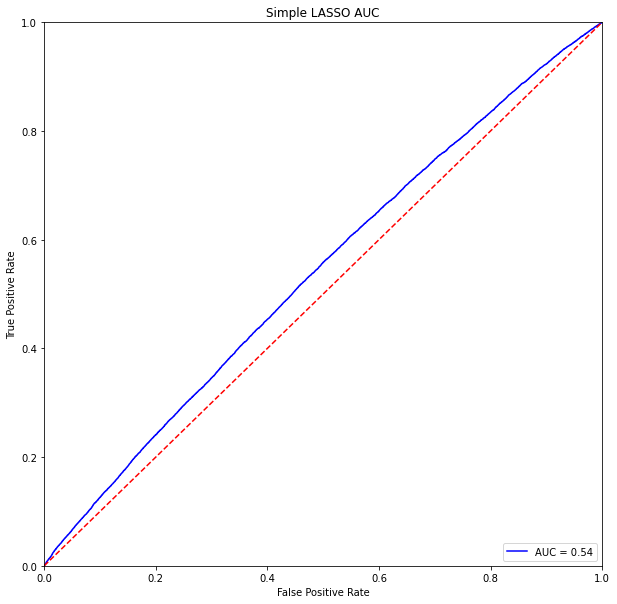

['11:65477306' '1:150456350' '11:65585257' '5:96374150' '5:96200770'
 '5:96257285' '11:65407886' '6:32438298' '6:32606941' '5:96101944'
 '6:32592605' '5:96323549' '5:96124330' '6:31239896' '6:31461771'
 '5:96057882' '1:150406172' '5:96092990' '1:150861859' '5:96115721'
 '5:96206563' '6:32581973' '6:32731258' '5:96147733' '6:32614080'
 '6:32789480' '6:32580657' '5:96128022' '5:96125330' '11:65640906'
 '11:65747057' '1:150467096' '1:150958977' '1:150635066' '1:150558293'
 '5:96185467' '5:95897963' '5:96198479' '6:29910358' '6:32636866'
 '11:65473798' '5:95999526' '5:96174446' '5:96229272' '1:150527294'
 '5:96174186' '5:96182717' '11:65583066' '1:150878649' '5:95981261'
 '6:31322980' '12:113411806' '11:65412467' '5:96120933' '5:96216387'
 '1:150737220' '5:95909680' '5:96293021' '6:32561327' '6:32610059'
 '1:150618632' '5:96151760' '6:32602396' '6:32575658' '6:32683121'
 '6:32389255' '6:32612397' '6:32592796' '6:32582194' '6:32584625'
 '6:32581582' '6:32583274']


In [43]:
#Now recreate model from fig. 7 using this new composite dataframe

#filter using LASSO regression
model = Lasso(alpha=0.000015,random_state=random_sate)  

# fit model
model.fit(SNP_outcome_cov_table_training_x, SNP_outcome_cov_table_training_y)

p = model.predict(SNP_outcome_cov_table_training_x)  # test the output by changing values
#Find model that gives best AUC, do a cutoff of weakest contributing SNPS, then run all analysis portions
# calculate the fpr and tpr for all thresholds of the classification
#preds = np.around(p, decimals=0, out=None)

preds=p
fpr, tpr, threshold = metrics.roc_curve(list(SNP_outcome_cov_table_training_y), preds,pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

print(roc_auc)
# method I: plt
plt.figure(figsize=(10,10))
plt.title('Simple LASSO AUC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#now drop SNPs with low contribution
print(SNP_outcome_cov_table_training_x.columns.values[model.coef_==0])


In [44]:
#remake SNP list with dropped "useless" SNPs
geneva_outcome_cov_table_dropped=geneva_outcome_cov_table.drop(SNP_outcome_cov_table_training_x.columns.values[model.coef_==0],axis=1)
SNP_outcome_cov_table_downsamp_dropped=SNP_outcome_cov_table_downsamp.drop(SNP_outcome_cov_table_training_x.columns.values[model.coef_==0],axis=1)

geneva_outcome_cov_table_x=geneva_outcome_cov_table_dropped.drop(['IID',
       'PRS', 'pheno', 'age', 'Gender_', 'Breslow_tumor_thickness',
       'family_history', 'sex', 'FID', 'SOL', 'C1', 'C2', 'C3', 'C4',
       'C5', 'C6', 'C7', 'C8', 'C9', 'C10'],axis=1)
geneva_outcome_cov_table_x.index=geneva_outcome_cov_table_dropped["IID"]
geneva_outcome_cov_table_x=geneva_outcome_cov_table_x.drop(["index_x","index_y"],axis=1)

geneva_outcome_cov_table_y=geneva_outcome_cov_table_dropped["pheno"]
geneva_outcome_cov_table_y.index=geneva_outcome_cov_table_dropped["IID"]

SNP_outcome_cov_table_training_x=SNP_outcome_cov_table_downsamp_dropped.drop(["IID","Cancer","C43-C44","C60-C63","AGE","SEX","PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10",'PRS',
       'FID', 'D55-D59', 'D80-D89', 'E70-E90', 'I70-I79', 'K20-K31',
       'K50-K52', 'K70-K77', 'K80-K87', 'K90-K93', 'L40-L45', 'M00-M03',
       'M05-M14', 'M15-M19', 'M20-M25', 'M70-M79', 'M45-M49', 'M60-M63',
       'R70-R79', 'C73-C75', 'C81-C96', 'D60-D64', 'C40-C41', 'D37-D48',
       'D70-D77', 'C50-C50', 'D65-D69', 'C00-C14', 'C45-C49', 'D00-D09',
       'C30-C39', 'C97-C97', 'D50-D53', 'C76-C80', 'C15-C26', 'C51-C58',
       'D10-D36', 'C69-C72', 'C64-C68',"AnyCancer"],axis=1)
SNP_outcome_cov_table_training_x.index=SNP_outcome_cov_table_downsamp_dropped["IID"]
SNP_outcome_cov_table_training_x=SNP_outcome_cov_table_training_x.drop(["level_0","index"],axis=1)
SNP_outcome_cov_table_training_y=SNP_outcome_cov_table_downsamp_dropped["Cancer"]
SNP_outcome_cov_table_training_y.index=SNP_outcome_cov_table_downsamp_dropped["IID"]

geneva_outcome_cov_table_dropped=geneva_outcome_cov_table_dropped.reset_index()

In [45]:
pd.DataFrame(SNP_outcome_cov_table_training_x.columns.values).to_csv("../data/risk_model/melanoma_final_snps.txt",sep="\t")

In [46]:
regressor_xgb = xgboost.XGBRFRegressor(n_estimators = 200, random_state = random_sate,learning_rate=0.3,max_depth=9,verbose_eval=10)
regressor_xgb.fit(SNP_outcome_cov_table_training_x, SNP_outcome_cov_table_training_y)  

p = regressor_xgb.predict(geneva_outcome_cov_table_x)  # test the output by changing values
p_disc=regressor_xgb.predict(SNP_outcome_cov_table_training_x)

geneva_outcome_cov_table_dropped["LASSO_burden"]=p
SNP_outcome_cov_table_downsamp_dropped["LASSO_burden"]=p_disc

[09:22:26] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "verbose_eval" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


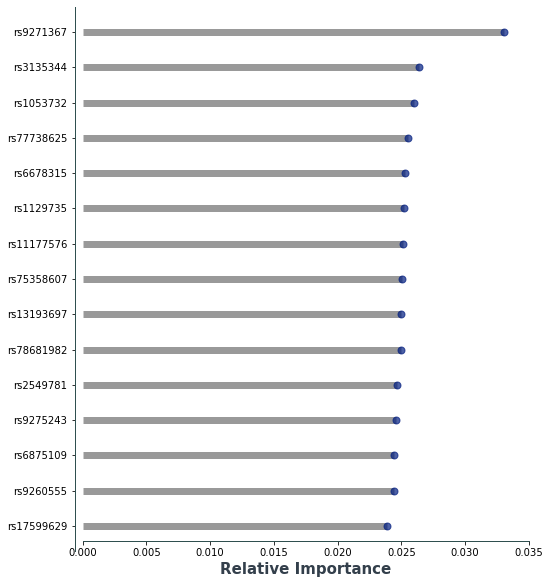

In [47]:
features = SNP_outcome_cov_table_training_x.columns.values.tolist()
features=[x.rsplit("_")[0] for x in features]
importances = regressor_xgb.feature_importances_

mapping_table=pd.concat([pd.DataFrame(features),pd.DataFrame(importances)],axis=1)
mapping_table.columns=["ID","importance"]

rsid_table=pd.read_csv("../tables/time-germline.csv",sep="\t")
rsid_table=rsid_table.drop_duplicates(subset="rsid")
rsid_table=rsid_table[["snp_noallele","rsid"]]

compiled_icb_rsid_plot=pd.merge(mapping_table,rsid_table,left_on="ID",right_on="snp_noallele")

compiled_icb_rsid_plot=compiled_icb_rsid_plot.sort_values(by="importance")
compiled_icb_rsid_plot=compiled_icb_rsid_plot.iloc[compiled_icb_rsid_plot.shape[0]-15:compiled_icb_rsid_plot.shape[0],:]

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

plt.rcParams['axes.edgecolor']='darkslategrey'
plt.rcParams['axes.linewidth']=1
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.style.use('seaborn-dark-palette')

my_range=list(range(0,len(compiled_icb_rsid_plot["importance"])))
fig, ax = plt.subplots(figsize=(8,10))
plt.hlines(y=my_range, xmin=0, xmax=compiled_icb_rsid_plot["importance"], alpha=0.4, linewidth=7)
plt.plot(compiled_icb_rsid_plot["importance"], my_range, "o", markersize=7, alpha=0.7)
# set labels style
ax.set_xlabel('Relative Importance', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')
# change the style of the axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_bounds((0, len(my_range)-1))
ax.set_xlim(0,0.035)
plt.yticks(range(len(compiled_icb_rsid_plot["importance"])), compiled_icb_rsid_plot["rsid"])
# add some space between the axis and the plot
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', -10))
plt.savefig("../plots/fig3/melanoma_feature_importance_V2.pdf",bbox_inches = "tight")


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


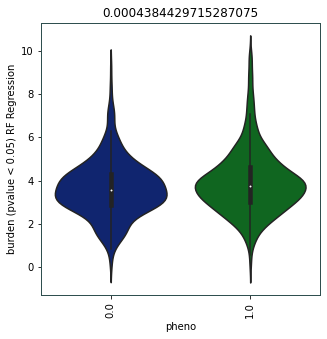

In [48]:
geneva_outcome_cov_table2=geneva_outcome_cov_table_dropped[geneva_outcome_cov_table_dropped["family_history"]!=1]
geneva_outcome_cov_table_plot=geneva_outcome_cov_table2
geneva_outcome_cov_table_plot=geneva_outcome_cov_table_plot.loc[geneva_outcome_cov_table_plot['LASSO_burden']<float(geneva_outcome_cov_table_plot['LASSO_burden'].quantile([0.99]))]
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 10))
x = geneva_outcome_cov_table_plot["LASSO_burden"].values.reshape(-1, 1)
geneva_outcome_cov_table_plot["LASSO_scaled"] = minmax_scale.fit_transform(x)

fig = plt.figure(figsize=(5,5))

sns.violinplot(x="pheno",y="LASSO_scaled",data=geneva_outcome_cov_table_plot)

cat1 = geneva_outcome_cov_table2[geneva_outcome_cov_table2["pheno"]==0]
cat2 = geneva_outcome_cov_table2[geneva_outcome_cov_table2["pheno"]==1]
disc_score=cat2["LASSO_burden"].mean()-cat1["LASSO_burden"].mean()

plt.title(stats.mannwhitneyu(cat1["LASSO_burden"], cat2["LASSO_burden"])[1])

plt.ylabel("burden (pvalue < 0.05) RF Regression")
plt.xticks(rotation=90)
#plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/melanomaViolin_FH_only_RescaledOutlierDroppedFromPlot.pdf")
plt.savefig("../plots/fig3/melanomaViolin_FH_only_rescaled_99th_dropped.pdf")

In [49]:
#restructure PRS score so that it makes more sense to plot
geneva_outcome_cov_table_dropped.columns.values
geneva_outcome_cov_table_dropped["PRS"]=geneva_outcome_cov_table_dropped["LASSO_burden"]
geneva_outcome_cov_table2["PRS"]=geneva_outcome_cov_table2["LASSO_burden"]

/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [50]:
geneva_outcome_odds=quantile_plot(geneva_outcome_cov_table2,"pheno ~ group + age + sex + C1 + C2 + C3 + C4 + C5 + C6 + C7 + C8 + C9 + C10",10,"logistic")

/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    169
0    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.551226
         Iterations 6


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    170
0    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.519002
         Iterations 6
1    169
0    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.545223
         Iterations 6
1    170
0    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.540988
         Iterations 6
1    169
0    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.501235
         Iterations 6
1    169
Name: group, dtype: int64


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

1    170
0    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.529732
         Iterations 6
1    170
0    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.508096
         Iterations 6
1    170
0    169
Name: group, dtype: int64


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Optimization terminated successfully.
         Current function value: 0.483214
         Iterations 6
1    169
0    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.464374
         Iterations 7


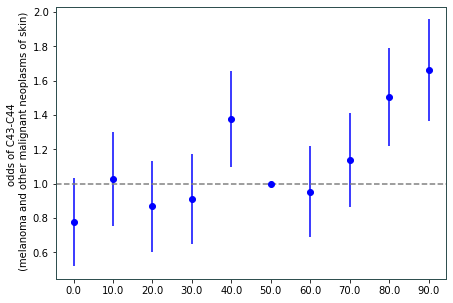

In [51]:
f=plt.figure(figsize=(7,5))

plt.errorbar(x=geneva_outcome_odds["quant"].tolist(),y=geneva_outcome_odds["odds"].tolist(),yerr=geneva_outcome_odds["se"].tolist(),fmt="o",color="blue",label="group1 + mhc genes")
plt.ylabel("quantile")
plt.ylabel("odds of C43-C44 \n (melanoma and other malignant neoplasms of skin)")
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("../plots/fig3/melanoma.quantile.FH.pdf")

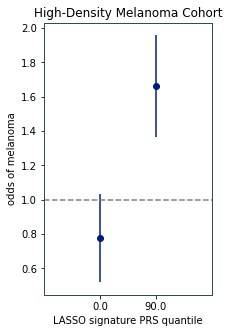

In [52]:
#1st vs 10th quantile
geneva_outcome_odds_filt=geneva_outcome_odds[geneva_outcome_odds["quant"].isin(["0.0","90.0"])]
f=plt.figure(figsize=(3,5))
plt.errorbar(x=geneva_outcome_odds_filt["quant"].tolist(),y=geneva_outcome_odds_filt["odds"].tolist(),yerr=geneva_outcome_odds_filt["se"].tolist(),fmt="o")
plt.xlabel("LASSO signature PRS quantile")
plt.ylabel("odds of melanoma")
plt.title("High-Density Melanoma Cohort")
plt.xticks([0,1])
plt.xlim((-1, 2))
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("../plots/fig3/1vs9_melanoma.quantile.pdf")

## Melanoma based TCGA inflammation

In [53]:
group1_sumstats=ukbb_annot[ukbb_annot["group"]=="group1"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
group1_sumstats=group1_sumstats[group1_sumstats["Outcome"]=="C43-C44"]
group1_sumstats.columns=["ID","A1","OR","Outcome"]

mhcII_sumstats=ukbb_annot[ukbb_annot["file"]=="Sigs160-Wolf_MHC2-21978456"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
mhcII_sumstats=mhcII_sumstats[mhcII_sumstats["Outcome"]=="C43-C44"]
mhcII_sumstats.columns=["ID","A1","OR","Outcome"]

group1_mhcII_sumstats=group1_sumstats.append(mhcII_sumstats)
group1_mhcII_sumstats

tcga_group1_prs,tcga_snp_table=make_ukbb_prs("../data/genotypes/all.time.raw",group1_mhcII_sumstats,group1_mhcII_sumstats["ID"].tolist())

124 PRS snps
0 snps missing weight
switching 108 genotypes


In [54]:
canc = pd.read_csv("/cellar/controlled/dbgap-genetic/phs000178_TCGA/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
tcga_group1_prs["cancer"]=tcga_group1_prs["IID"].map(mp)
tcga_group1_prs_SKCM=tcga_group1_prs[tcga_group1_prs["cancer"]=="SKCM"]

tcga_snp_table=tcga_snp_table[tcga_group1_prs_SKCM["IID"]]
tcga_snp_table=tcga_snp_table.transpose()

In [55]:
#trim tcga_snp_table down to model feature space
tcga_snp_table_test=tcga_snp_table[geneva_outcome_cov_table_x.columns.values]

In [56]:
p = regressor_xgb.predict(tcga_snp_table_test)  # test the output by changing values
tcga_snp_table_test["LASSO_burden"]=p
tcga_group1_prs_SKCM["LASSO_burden"]=p

/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [57]:
#get cibersortx data
ciber_lm22=pd.read_csv("../data/plink-associations/phenotypes/TCGA.Kallisto.fullIDs.cibersort.relative.tsv",delimiter="\t")
ciber_lm22["id"]=ciber_lm22["SampleID"].str.replace(".","-")
ciber_lm22["code"]=ciber_lm22["id"].str.rsplit("-",4).str[1]
ciber_lm22["id"]=ciber_lm22["id"].str.rsplit("-",4).str[0]
ciber_lm22=ciber_lm22[ciber_lm22["code"].str.contains("01")]
ciber_lm22.index=ciber_lm22["id"]
ciber_lm22=ciber_lm22[ciber_lm22.columns[2:-5].tolist()]
ciber_lm22=ciber_lm22.groupby(ciber_lm22.index).mean()
ciber_lm22=ciber_lm22.reset_index().rename(columns={"id":"IID"})
tcga_group1_prs=pd.merge(tcga_group1_prs_SKCM,ciber_lm22,on="IID",how="left")

missing T.cells.gamma.delta


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


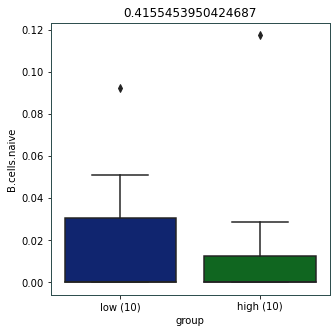

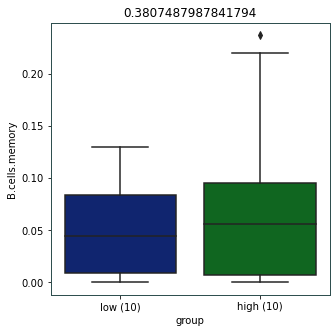

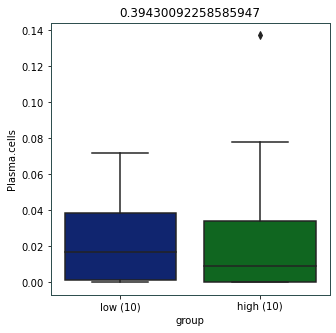

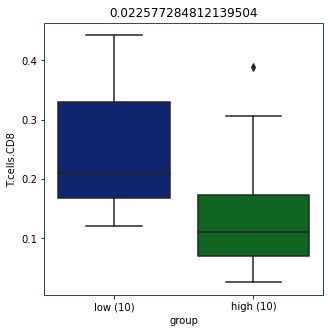

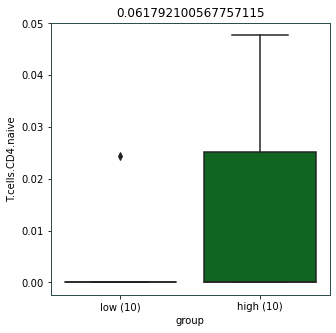

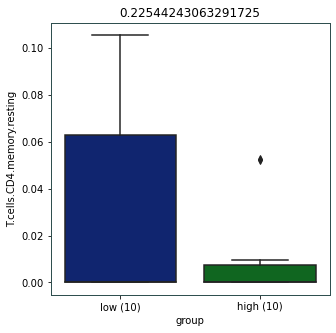

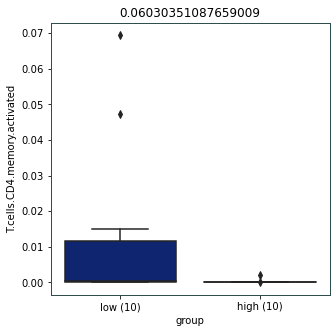

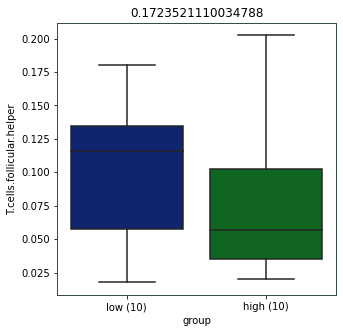

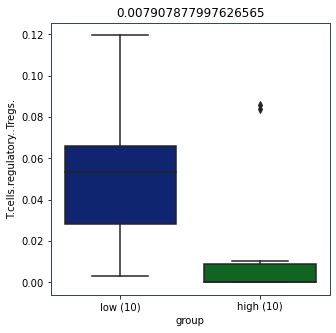

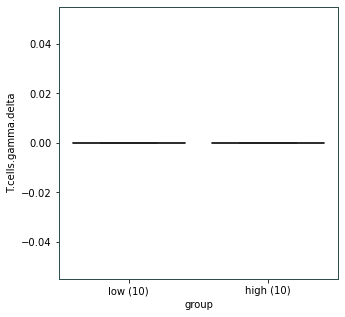

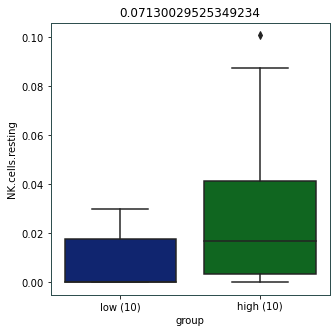

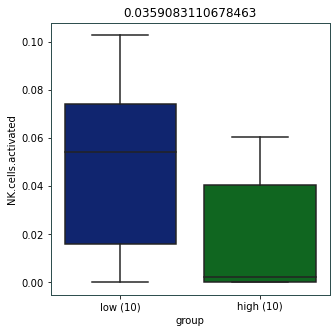

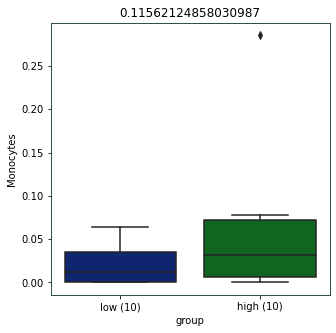

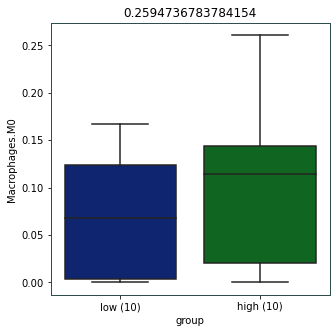

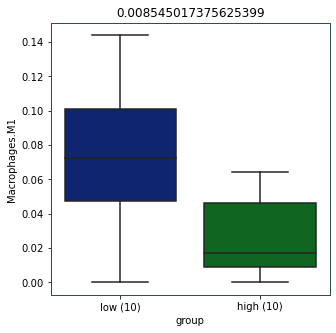

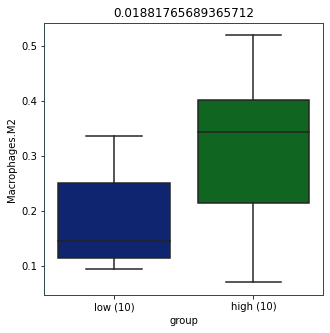

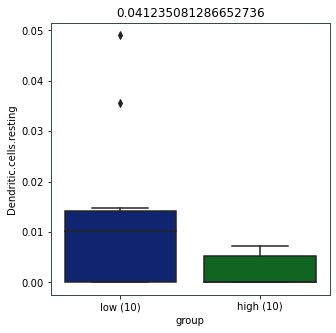

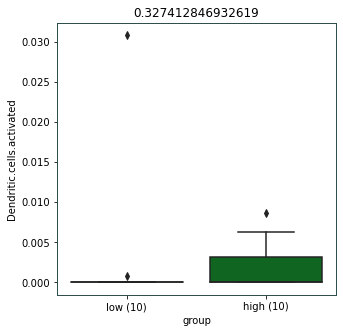

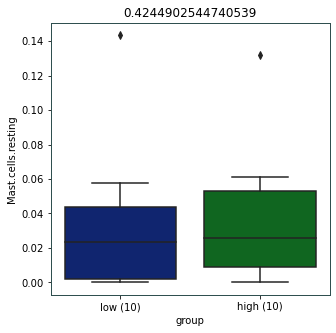

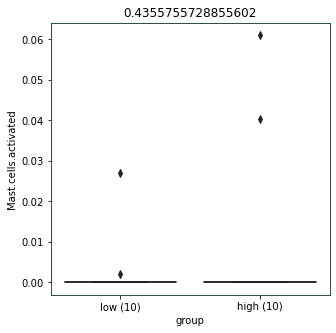

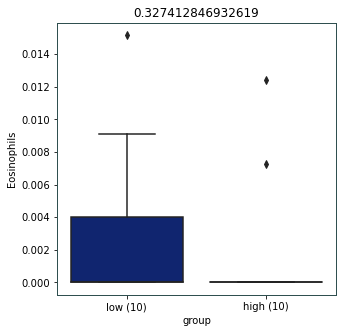

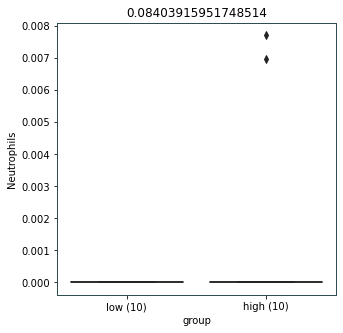

In [58]:
for x in tcga_group1_prs.columns[4:]:
    f=plt.figure(figsize=(5,5))
    pheno=x 
    tcga_group1_prs_cancer=tcga_group1_prs[tcga_group1_prs["cancer"]=="SKCM"]
    tcga_group1_prs_cancer=tcga_group1_prs_cancer[~tcga_group1_prs_cancer[x].isnull()]
    
    tcga_group1_prs_cancer["group"]=np.where(tcga_group1_prs_cancer["LASSO_burden"]>tcga_group1_prs_cancer["LASSO_burden"].quantile(0.9),"high","medium")
    tcga_group1_prs_cancer["group"]=np.where(tcga_group1_prs_cancer["LASSO_burden"]<tcga_group1_prs_cancer["LASSO_burden"].quantile(0.1),"low",tcga_group1_prs_cancer["group"])

    ax=sns.boxplot(x="group",y=pheno,data=tcga_group1_prs_cancer,order=["low","high"])
    labels=[item.get_text() for item in ax.get_xticklabels()]
    labels=[x+" ("+str(len(tcga_group1_prs_cancer[tcga_group1_prs_cancer["group"]==x]))+")" for x in labels]
    ax.set_xticklabels(labels)
    
    try:
        cat1 = tcga_group1_prs_cancer[(tcga_group1_prs_cancer["group"]=="low")]
        cat2 = tcga_group1_prs_cancer[(tcga_group1_prs_cancer["group"]=="high")]
        plt.title(str(mannwhitneyu(cat1[pheno], cat2[pheno])[1]))
        plt.savefig("../plots/fig3/melanoma.PRS."+x+".pdf")
    except:
        print("missing {}".format(pheno))

In [59]:
mac_plot=pd.melt(tcga_group1_prs_cancer,id_vars=["IID","group"],value_vars=["Macrophages.M1","Macrophages.M2"])
mac_plot=mac_plot[mac_plot["group"].isin(["low","high"])]

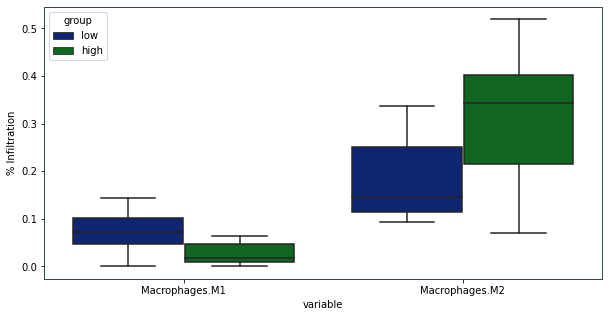

In [60]:
f=plt.figure(figsize=(10,5))
sns.boxplot(x="variable",hue="group",y="value",data=mac_plot)
plt.ylabel('% Infiltration')
plt.savefig("../plots/fig3/mac.pdf")

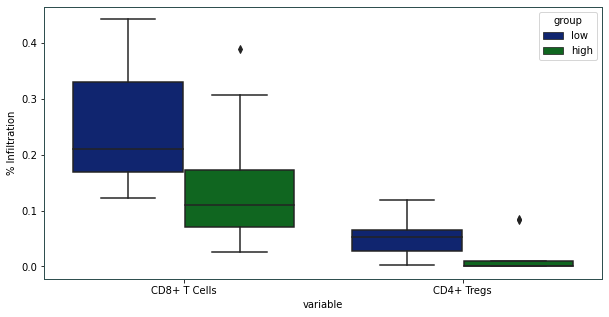

In [61]:
tcga_group1_prs_cancer=tcga_group1_prs_cancer.rename(columns={"T.cells.regulatory..Tregs.": "CD4+ Tregs", "T.cells.CD8": "CD8+ T Cells"})
T_plot=pd.melt(tcga_group1_prs_cancer,id_vars=["IID","group"],value_vars=["CD8+ T Cells","CD4+ Tregs"])
T_plot=T_plot[T_plot["group"].isin(["low","high"])]
f=plt.figure(figsize=(10,5))
sns.boxplot(x="variable",hue="group",y="value",data=T_plot)
plt.ylabel('% Infiltration')
plt.savefig("../plots/fig3/Tcells.pdf")

### UKBB with combined MHC+group1 SNPs, protstate training and validation ONLY

#### Prostate Genes ONLY

In [62]:
group1_sumstats=ukbb_annot[ukbb_annot["group"]=="group1"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
group1_sumstats=group1_sumstats[group1_sumstats["Outcome"]=="C60-C63"]
group1_sumstats.columns=["ID","A1","OR","Outcome"]

mhcII_sumstats=ukbb_annot[ukbb_annot["file"]=="Sigs160-Wolf_MHC2-21978456"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
mhcII_sumstats=mhcII_sumstats[mhcII_sumstats["Outcome"]=="C60-C63"]
mhcII_sumstats.columns=["ID","A1","OR","Outcome"]

group1_mhcII_sumstats=group1_sumstats.append(mhcII_sumstats)
group1_mhcII_sumstats

group1_mhc_prs,test_ukbb_res=make_ukbb_prs("../data/ukbb/time-snp/dosage-multi/ukbb_bialleleic.raw",group1_mhcII_sumstats,group1_mhcII_sumstats["ID"].tolist())
icd=pd.read_csv("/cellar/users/mpagadal/data/ukbb/plato_input/immune_cancer_lev1_pheno.txt",delim_whitespace=True)
group1_mhc_prs=pd.merge(group1_mhc_prs,icd,on="IID",how="left")

57 PRS snps
0 snps missing weight
switching 53 genotypes


In [63]:
#merge group1_mhc_prs with raw SNP data then format for model building
group1_mhc_prs_short=group1_mhc_prs[["IID","C43-C44","C60-C63","AGE","SEX","PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10"]]
test_ukbb_res_t=test_ukbb_res.transpose()
SNP_outcome_cov_table=pd.merge(test_ukbb_res_t,group1_mhc_prs,right_on="IID",how="left",left_index=True)

In [64]:
SNP_outcome_cov_table["Cancer"]=SNP_outcome_cov_table[["C43-C44","C60-C63"]].max(axis=1)
np.nansum(SNP_outcome_cov_table["Cancer"]),np.nansum(SNP_outcome_cov_table["C43-C44"]),np.nansum(SNP_outcome_cov_table["C60-C63"])

(21701.0, 14960.0, 7291.0)

In [65]:
#Try joint gene score but slim down to melanoma only
SNP_outcome_cov_table.columns.values
SNP_outcome_cov_table["AnyCancer"]=SNP_outcome_cov_table[['C73-C75', 'C81-C96', 'C40-C41',
        'C50-C50',  'C00-C14', 'C45-C49',
       'C30-C39', 'C97-C97', 'C76-C80', 'C60-C63',
       'C15-C26', 'C51-C58', 'C43-C44', 'C69-C72', 'C64-C68']].max(axis=1)

SNP_outcome_cov_table=SNP_outcome_cov_table[np.logical_or(SNP_outcome_cov_table["C60-C63"]==1,SNP_outcome_cov_table["AnyCancer"]==0)]
SNP_outcome_cov_table["Cancer"]=SNP_outcome_cov_table[["C60-C63"]].max(axis=1)

In [66]:
SNP_outcome_cov_table=SNP_outcome_cov_table.reset_index()
SNP_outcome_cov_table=SNP_outcome_cov_table[~SNP_outcome_cov_table["Cancer"].isnull()]

In [67]:
SNP_outcome_cov_table = SNP_outcome_cov_table.reset_index()

In [68]:
# Separate majority and minority classes
df_majority = SNP_outcome_cov_table[SNP_outcome_cov_table["Cancer"]==0]
df_minority = SNP_outcome_cov_table[SNP_outcome_cov_table["Cancer"]==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, random_state=random_sate,
                                 replace=False,    
                                 n_samples=len(df_majority))
print(df_majority_downsampled.shape)

# Combine minority class with downsampled majority class
SNP_outcome_cov_table_downsamp = pd.concat([df_majority_downsampled, df_minority])

(341376, 112)


In [69]:
SNP_outcome_cov_table_training_x=SNP_outcome_cov_table_downsamp.drop(["IID","Cancer","C43-C44","C60-C63","AGE","SEX","PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10",'PRS',
       'FID', 'D55-D59', 'D80-D89', 'E70-E90', 'I70-I79', 'K20-K31',
       'K50-K52', 'K70-K77', 'K80-K87', 'K90-K93', 'L40-L45', 'M00-M03',
       'M05-M14', 'M15-M19', 'M20-M25', 'M70-M79', 'M45-M49', 'M60-M63',
       'R70-R79', 'C73-C75', 'C81-C96', 'D60-D64', 'C40-C41', 'D37-D48',
       'D70-D77', 'C50-C50', 'D65-D69', 'C00-C14', 'C45-C49', 'D00-D09',
       'C30-C39', 'C97-C97', 'D50-D53', 'C76-C80', 'C15-C26', 'C51-C58',
       'D10-D36', 'C69-C72', 'C64-C68','AnyCancer'],axis=1)
SNP_outcome_cov_table_training_x.index=SNP_outcome_cov_table_downsamp["IID"]
SNP_outcome_cov_table_training_x=SNP_outcome_cov_table_training_x.drop(["level_0","index"],axis=1)
SNP_outcome_cov_table_training_y=SNP_outcome_cov_table_downsamp["Cancer"]
SNP_outcome_cov_table_training_y.index=SNP_outcome_cov_table_downsamp["IID"]

### Generating and preparing the validation datasets

In [70]:
ellipse_prs,ellipse_snps=make_ukbb_prs("../data/genotypes/ellipse/ellipse.raw",group1_mhcII_sumstats,group1_mhcII_sumstats["ID"].tolist())
#add phenotyping
pheno=pd.read_csv("/cellar/controlled/dbgap-genetic/phs001120.v1.p1_ellipse/phenotypes/pheno_affection_status.txt",delimiter="\t",header=None)
pheno[2]=pheno[2].map({1:0,2:1})

mp_pheno=dict(zip(pheno[1],pheno[2]))

ellipse_prs["pheno"]=ellipse_prs["IID"].map(mp_pheno)
cov=pd.read_csv("/cellar/controlled/dbgap-genetic/phs001120.v1.p1_ellipse/covs/age-pcs-fh",delimiter="\t")
ellipse_prs=pd.merge(ellipse_prs,cov,on="IID",how="left")
ellipse_prs["FH_PROS"]=ellipse_prs["FH_PROS"].replace(-9,0)

ellipse_prs["FID"]=ellipse_prs["IID"]

#Merge geneva_prs file with SNP inputs, then chop up into train/test
ellipse_snps_t=ellipse_snps.transpose()
ellipse_snps_t["IID"]=ellipse_snps_t.index

ellipse_snps_t = ellipse_snps_t.reset_index()
ellipse_prs = ellipse_prs.reset_index()

ellipse_snps_t["IID"]=ellipse_snps_t['IID'].astype(str)
ellipse_prs["IID"]=ellipse_prs['IID'].astype(str)

ellipse_outcome_cov_table=pd.merge(pd.DataFrame(ellipse_snps_t),pd.DataFrame(ellipse_prs),on="IID",how="left")

57 PRS snps
0 snps missing weight
switching 45 genotypes


In [71]:
ellipse_outcome_cov_table=ellipse_outcome_cov_table[~ellipse_outcome_cov_table["pheno"].isnull()]

ellipse_outcome_cov_table_x=ellipse_outcome_cov_table.drop(['IID',
       'PRS', 'pheno', 'age',
       'FH_PROS', 'FID', 'PC1', 'PC2', 'PC3', 'PC4',
       'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'],axis=1)

ellipse_outcome_cov_table_x.index=ellipse_outcome_cov_table["IID"]
ellipse_outcome_cov_table_x=ellipse_outcome_cov_table_x.drop(["index_x","index_y"],axis=1)

ellipse_outcome_cov_table_y=ellipse_outcome_cov_table["pheno"]
ellipse_outcome_cov_table_y.index=ellipse_outcome_cov_table["IID"]

In [72]:
SNP_outcome_cov_table_training_y=pd.to_numeric(SNP_outcome_cov_table_training_y, errors='coerce').astype("Int32")
ellipse_outcome_cov_table_y=pd.to_numeric(ellipse_outcome_cov_table_y, errors='coerce').astype("Int32")

In [73]:
#Minor lack of overlap in SNPs from training to testing dataset, so need to pare down training table to SNPs that exist in the ellipse cohort
SNP_outcome_cov_table_training_x=SNP_outcome_cov_table_training_x[ellipse_outcome_cov_table_x.columns.values]

In [74]:
SNP_outcome_cov_table_training_x.shape,SNP_outcome_cov_table_training_y.shape,ellipse_outcome_cov_table_x.shape,ellipse_outcome_cov_table_y.shape

((348667, 50), (348667,), (91644, 50), (91644,))

In [75]:
preds

array([0.04647482, 0.04205098, 0.04489412, ..., 0.04191032, 0.03472614,
       0.04742778])

0.5382223014559917


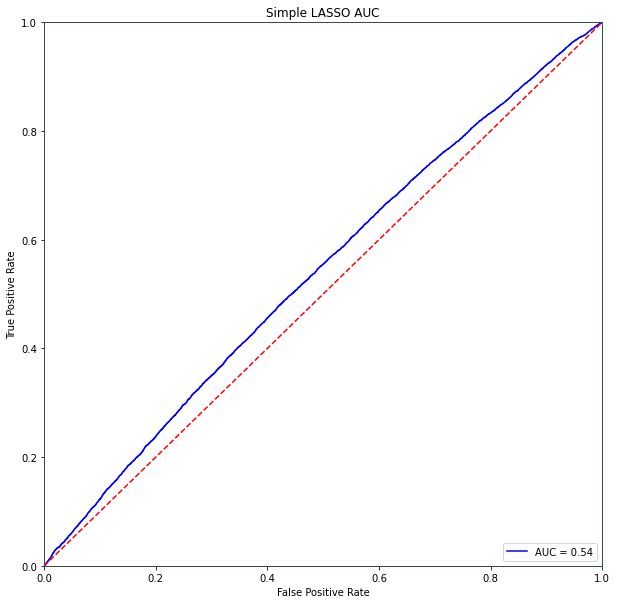

['6:32651641' '6:32438298' '6:29933439' '11:10490415' '6:26364628'
 '5:96124330' '1:150861859' '11:10489826' '6:32634243' '5:96216173'
 '5:96115146' '5:95981776' '1:150558293' '6:29910358' '5:96229272'
 '6:31322980' '6:32204433' '6:32602396' '6:32635629' '6:32212241'
 '6:32647701' '6:32575658' '6:32659609' '6:32134510']


In [76]:
# define model
model = Lasso(alpha=0.00001,random_state=random_sate)
# fit model
model.fit(SNP_outcome_cov_table_training_x, SNP_outcome_cov_table_training_y)
p = model.predict(SNP_outcome_cov_table_training_x)  
preds=p
#Find model that gives best AUC, do a cutoff of weakest contributing SNPS, then run all analysis port../tables/reds=p
fpr, tpr, threshold = metrics.roc_curve(list(SNP_outcome_cov_table_training_y), preds,pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)
plt.figure(figsize=(10,10))
plt.title('Simple LASSO AUC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#now drop SNPs with low contribution
print(SNP_outcome_cov_table_training_x.columns.values[model.coef_==0])

In [77]:
#remake SNP list with dropped "useless" SNPs

ellipse_outcome_cov_table=ellipse_outcome_cov_table.drop(SNP_outcome_cov_table_training_x.columns.values[model.coef_==0],axis=1)
SNP_outcome_cov_table_downsamp=SNP_outcome_cov_table_downsamp.drop(SNP_outcome_cov_table_training_x.columns.values[model.coef_==0],axis=1)

ellipse_outcome_cov_table_x=ellipse_outcome_cov_table.drop(['IID',
       'PRS', 'pheno', 'age',
       'FH_PROS', 'FID', 'PC1', 'PC2', 'PC3', 'PC4',
       'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'],axis=1)
ellipse_outcome_cov_table_x.index=ellipse_outcome_cov_table["IID"]
ellipse_outcome_cov_table_x=ellipse_outcome_cov_table_x.drop(["index_x","index_y"],axis=1)

ellipse_outcome_cov_table_y=ellipse_outcome_cov_table["pheno"]
ellipse_outcome_cov_table_y.index=ellipse_outcome_cov_table["IID"]

SNP_outcome_cov_table_training_x=SNP_outcome_cov_table_downsamp.drop(["IID","Cancer","C43-C44","C60-C63","AGE","SEX","PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10",'PRS',
       'FID', 'D55-D59', 'D80-D89', 'E70-E90', 'I70-I79', 'K20-K31',
       'K50-K52', 'K70-K77', 'K80-K87', 'K90-K93', 'L40-L45', 'M00-M03',
       'M05-M14', 'M15-M19', 'M20-M25', 'M70-M79', 'M45-M49', 'M60-M63',
       'R70-R79', 'C73-C75', 'C81-C96', 'D60-D64', 'C40-C41', 'D37-D48',
       'D70-D77', 'C50-C50', 'D65-D69', 'C00-C14', 'C45-C49', 'D00-D09',
       'C30-C39', 'C97-C97', 'D50-D53', 'C76-C80', 'C15-C26', 'C51-C58',
       'D10-D36', 'C69-C72', 'C64-C68'],axis=1)
SNP_outcome_cov_table_training_x.index=SNP_outcome_cov_table_downsamp["IID"]
SNP_outcome_cov_table_training_x=SNP_outcome_cov_table_training_x.drop(["level_0","index"],axis=1)
SNP_outcome_cov_table_training_y=SNP_outcome_cov_table_downsamp["Cancer"]
SNP_outcome_cov_table_training_y.index=SNP_outcome_cov_table_downsamp["IID"]

ellipse_outcome_cov_table=ellipse_outcome_cov_table.reset_index()

SNP_outcome_cov_table_training_x=SNP_outcome_cov_table_training_x[ellipse_outcome_cov_table_x.columns.values]

In [78]:
pd.DataFrame(ellipse_outcome_cov_table_x.columns.values).to_csv("../data/risk_model/prostate_final_snps.txt",sep="\t")

In [79]:
regressor_xgb = xgboost.XGBRFRegressor(n_estimators = 200, random_state = random_sate,learning_rate=0.1,max_depth=9,verbose_eval=10)
regressor_xgb.fit(SNP_outcome_cov_table_training_x, SNP_outcome_cov_table_training_y)  

p = regressor_xgb.predict(ellipse_outcome_cov_table_x)  # test the output by changing values
p_disc=regressor_xgb.predict(SNP_outcome_cov_table_training_x)

ellipse_outcome_cov_table["LASSO_burden"]=p
SNP_outcome_cov_table_downsamp["LASSO_burden"]=p_disc

[09:27:45] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "verbose_eval" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




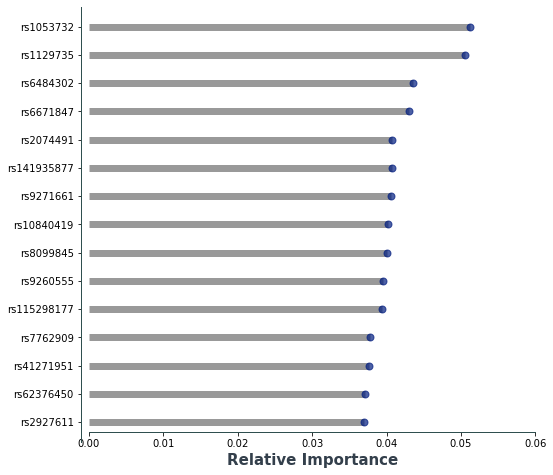

In [80]:
features = SNP_outcome_cov_table_training_x.columns.values.tolist()
features=[x.rsplit("_")[0] for x in features]
importances = regressor_xgb.feature_importances_

mapping_table=pd.concat([pd.DataFrame(features),pd.DataFrame(importances)],axis=1)
mapping_table.columns=["ID","importance"]

rsid_table=pd.read_csv("../tables/time-germline.csv",sep="\t")
rsid_table=rsid_table.drop_duplicates(subset="rsid")
rsid_table=rsid_table[["snp_noallele","rsid"]]

compiled_icb_rsid_plot=pd.merge(mapping_table,rsid_table,left_on="ID",right_on="snp_noallele")

compiled_icb_rsid_plot=compiled_icb_rsid_plot.sort_values(by="importance")
compiled_icb_rsid_plot=compiled_icb_rsid_plot.iloc[compiled_icb_rsid_plot.shape[0]-15:compiled_icb_rsid_plot.shape[0],:]

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

plt.rcParams['axes.edgecolor']='darkslategrey'
plt.rcParams['axes.linewidth']=1
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.style.use('seaborn-dark-palette')

my_range=list(range(0,len(compiled_icb_rsid_plot["importance"])))
fig, ax = plt.subplots(figsize=(8,8))
plt.hlines(y=my_range, xmin=0, xmax=compiled_icb_rsid_plot["importance"], alpha=0.4, linewidth=7)
plt.plot(compiled_icb_rsid_plot["importance"], my_range, "o", markersize=7, alpha=0.7)
# set labels style
ax.set_xlabel('Relative Importance', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')
# change the style of the axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_bounds((0, len(my_range)-1))
ax.set_xlim(0,0.06)
plt.yticks(range(len(compiled_icb_rsid_plot["importance"])), compiled_icb_rsid_plot["rsid"])
# add some space between the axis and the plot
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', -10))

plt.savefig("../plots/fig3/prostate_feature_importance_V2.pdf",bbox_inches = "tight")


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


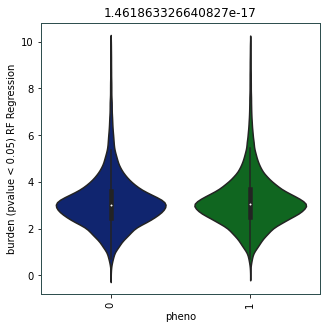

In [81]:
ellipse_outcome_cov_table_plot=ellipse_outcome_cov_table[ellipse_outcome_cov_table['LASSO_burden']<float(ellipse_outcome_cov_table['LASSO_burden'].quantile([0.99]))]
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 10))
x = ellipse_outcome_cov_table_plot["LASSO_burden"].values.reshape(-1, 1)
ellipse_outcome_cov_table_plot["LASSO_scaled"] = minmax_scale.fit_transform(x)

fig = plt.figure(figsize=(5,5))

#sns.boxplot(x="pheno",y="LASSO_scaled",data=ellipse_outcome_cov_table_plot)
sns.violinplot(x="pheno",y="LASSO_scaled",data=ellipse_outcome_cov_table_plot)


cat1 = ellipse_outcome_cov_table[ellipse_outcome_cov_table["pheno"]==0]
cat2 = ellipse_outcome_cov_table[ellipse_outcome_cov_table["pheno"]==1]
disc_score=cat2["LASSO_burden"].mean()-cat1["LASSO_burden"].mean()

plt.title(stats.mannwhitneyu(cat1["LASSO_burden"], cat2["LASSO_burden"])[1])

plt.ylabel("burden (pvalue < 0.05) RF Regression")
plt.xticks(rotation=90)
plt.savefig("../plots/fig3/prostateViolin_0.99_quantile_Dropped_rescaled.pdf")

In [82]:
#restructure PRS score so that it makes more sense to plot
ellipse_outcome_cov_table["PRS"]=ellipse_outcome_cov_table["LASSO_burden"]

In [83]:
ellipse_outcome_odds=quantile_plot(ellipse_outcome_cov_table,"pheno ~ group + age + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10",10,"logistic")

/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    9164
0    9155
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.633312
         Iterations 6


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    9163
0    9155
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.633945
         Iterations 6


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    9157
0    9155
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.633066
         Iterations 6


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    9158
0    9155
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.630499
         Iterations 6


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    9158
0    9155
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.632314
         Iterations 6


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    9155
Name: group, dtype: int64
1    9162
0    9155
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.630556
         Iterations 6


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    9156
0    9155
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.626826
         Iterations 6


/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    9162
0    9155
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.627650
         Iterations 6
1    9163
0    9155
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.628002
         Iterations 6


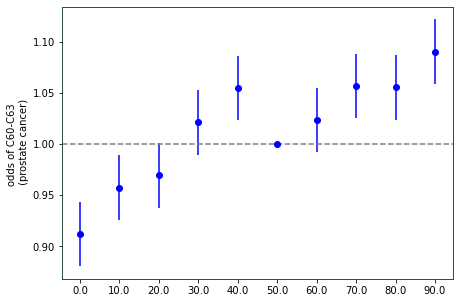

In [84]:
f=plt.figure(figsize=(7,5))
plt.errorbar(x=ellipse_outcome_odds["quant"].tolist(),y=ellipse_outcome_odds["odds"].tolist(),yerr=ellipse_outcome_odds["se"].tolist(),fmt="o",color="blue",label="group1 + mhc genes")
plt.ylabel("quantile")
plt.ylabel("odds of C60-C63 \n (prostate cancer)")
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("../plots/fig3/ellipse.quantile.pdf")

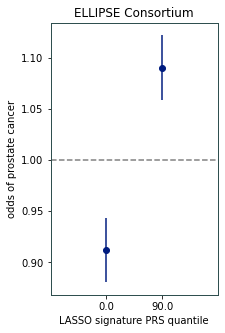

In [85]:
#1st vs 10th quantile
ellipse_outcome_odds_filt=ellipse_outcome_odds[ellipse_outcome_odds["quant"].isin(["0.0","90.0"])]
f=plt.figure(figsize=(3,5))
plt.errorbar(x=ellipse_outcome_odds_filt["quant"].tolist(),y=ellipse_outcome_odds_filt["odds"].tolist(),yerr=ellipse_outcome_odds_filt["se"].tolist(),fmt="o")
plt.xlabel("LASSO signature PRS quantile")
plt.ylabel("odds of prostate cancer")
plt.xticks([0,1])
plt.xlim((-1, 2))
plt.title("ELLIPSE Consortium")
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("../plots/fig3/1vs9_prostate.quantile.pdf")